# Creating and exporting a Time-depth table

There are many approaches you can use to create a time-depth table. It's possible to use experimental data equations, only the seismic, only well logs, only markers. But the best solution comes with the integration of all those methods. Here I propose the use of geological markers to export a time-depth table. But the code can be edited to include also geophysical markers - contrast of impedance observed at the logs. For this, first I will import the raw data (already integrated in the previous steps) and plot them. The identification of geophysical markers need to be done visually here. 

In [1]:
import numpy as np
import las
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import interpolate
import math
import pandas as pd

In [2]:
las_file = ('Resultados/RJS-203/out_lasio.las')

In [3]:
logs = las.LASReader(las_file)
logs.data

array([(  155.04,  nan,     nan), (  155.19,  nan,     nan),
       (  155.34,  nan,     nan), ..., ( 3030.5 ,  nan,  2.5598),
       ( 3030.7 ,  nan,  2.5518), ( 3030.8 ,  nan,  2.5465)],
      dtype=[('DEPT', '<f8'), ('DT', '<f8'), ('RHOB', '<f8')])

In [4]:
DT = logs.data['DT']
DT[-1]

nan

In [5]:
RHOB = logs.data['RHOB']
RHOB[-1]

2.5465

In [6]:
DEPT = logs.data['DEPT']
DEPT[-1]

3030.8000000000002

In [7]:
DEPT_start = np.amin(DEPT)
DEPT_start

155.03999999999999

In [8]:
DEPT_end = np.amax(DEPT)
DEPT_end

3030.8000000000002

In [9]:
STEP = logs.step
STEP

0.1524

## Inserting geological markers

In [10]:
#SB = logs.well.APD.value + (logs.well.EGL.value*-1)    # sea bottom depth at the ANP .las data
#SB

In [11]:
SB = logs.well.EGL.value*-1       # sea bottom depth at the data processed here
SB

43.0

In [12]:
markers = ('Fm. Embore', 'Fm. Macae/Mb. Goitacas', 'Fm. Lagoa Feia/Mb. Retiro', 'Mb. Itabapoana'  )

In [13]:
depths_markers = (SB, 1842, 1918, 1977  )

## Exporting markers

In [14]:
Markers = np.asarray([markers])
Markers.T

array([['Fm. Embore'],
       ['Fm. Macae/Mb. Goitacas'],
       ['Fm. Lagoa Feia/Mb. Retiro'],
       ['Mb. Itabapoana']],
      dtype='|S25')

In [15]:
Depths_markers = np.asarray([depths_markers])
Depths_markers.T

array([[   43.],
       [ 1842.],
       [ 1918.],
       [ 1977.]])

In [16]:
Markers = np.concatenate((Depths_markers.T, Markers.T), axis=1)
Markers

array([['43.0', 'Fm. Embore'],
       ['1842.0', 'Fm. Macae/Mb. Goitacas'],
       ['1918.0', 'Fm. Lagoa Feia/Mb. Retiro'],
       ['1977.0', 'Mb. Itabapoana']],
      dtype='|S32')

In [17]:
np.savetxt('Resultados/RJS-51/markers.txt', Markers, fmt= '%s', delimiter='    ', newline='\n', header='', footer='', comments='# ') 

## Using markers to create a layers model

In [18]:
depths_bottom = np.append(depths_markers[1:], DEPT_end)
depths_bottom

array([ 1842. ,  1918. ,  1977. ,  3030.8])

In [19]:
N_markers = len(markers)

for i in range(N_markers):
    idx_top = (np.abs(DEPT - depths_markers[i])).argmin()
    idx_bottom = (np.abs(DEPT - depths_bottom[i])).argmin()
    
    globals()['layer%s' % i] = DEPT[idx_top:idx_bottom]

In [20]:
thickness_layers=[]

for i in range(N_markers):
    thickness_l = globals()['layer%s' % i][-1] - globals()['layer%s' % i][0]
    thickness_layers = np.append(thickness_layers, thickness_l)
print thickness_layers

[ 1686.76    75.9     58.8   1053.7 ]


In [21]:
total_layers = np.append(depths_markers, DEPT_end)
total_layers

array([   43. ,  1842. ,  1918. ,  1977. ,  3030.8])

In [22]:
thickness_total_layers=[]

N = total_layers.size

for i in range(N-1):
    thickness_t = total_layers[i+1] - total_layers[i]
    thickness_total_layers = np.append(thickness_total_layers, thickness_t)

#np.set_printoptions(formatter={'float_kind':'{:f}'.format})    
print thickness_total_layers

[ 1799.     76.     59.   1053.8]


## Plotting the data:

In [23]:
title = 'RJS-203'

In [24]:
# Create the figure and subplots

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


def combo_plot(top_depth,bottom_depth):
    
    #plt.hold(True)
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,20), sharey=True)
    fig.suptitle(title, fontsize=22)
    fig.subplots_adjust(top=0.9,wspace=0.1)
    
#General setting for all axis
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False) 
        for (i,j) in zip(depths_markers,markers):
            if ((i>=top_depth) and (i<=bottom_depth)):
                axes.axhline(y=i, linewidth=0.5, color='black')
                axes.text(0.2, i ,j, horizontalalignment='left',verticalalignment='top')
    
    
#1st track: DT
    
    ax01=ax[0].twiny()
    ax01.set_xlim(240.0,40.0)
    ax01.spines['top'].set_position(('outward',0))
    ax01.set_xlabel("DT [Us/foot]")
    ax01.plot(DT, DEPT, label='DT[Us/foot]', color='black')
    ax01.set_xlabel('DT[Us/foot]',color='black')    
    ax01.tick_params(axis='x', colors='black')
    ax01.grid(True)
    
#2nd track: RHOB

    ax11=ax[1].twiny()
    ax11.set_xlim(0,3.0)
    ax11.grid(True)
    ax11.spines['top'].set_position(('outward',0))
    ax11.set_xlabel('RHOB[g/cc]', color='red')
    ax11.plot(RHOB, DEPT, label='RHOB[g/cc]', color='red')
    ax11.tick_params(axis='x', colors='red') 
    
#3rd track: Layers

    NL = total_layers.size-1
    cmap = get_cmap(NL)
    
    ax21=ax[2].twiny()
    ax21.set_xlim([ -150, 150])
    ax21.grid(True)
    
    x = 'Model with'
    y = NL
    z = 'layers'
    
    ax21.set_xlabel('%s %s %s'%(x, y, z), color='black')
    
    
    
    for i in range(NL):
        rect = plt.Rectangle((-150, total_layers[i]), 300, thickness_total_layers[i], alpha = 0.3, facecolor=cmap(i))
        ax21.add_artist(rect)
        
    ax21.set_xticks([])

    
    #plt.savefig ('RJS_426.png', dpi=200, format='png')

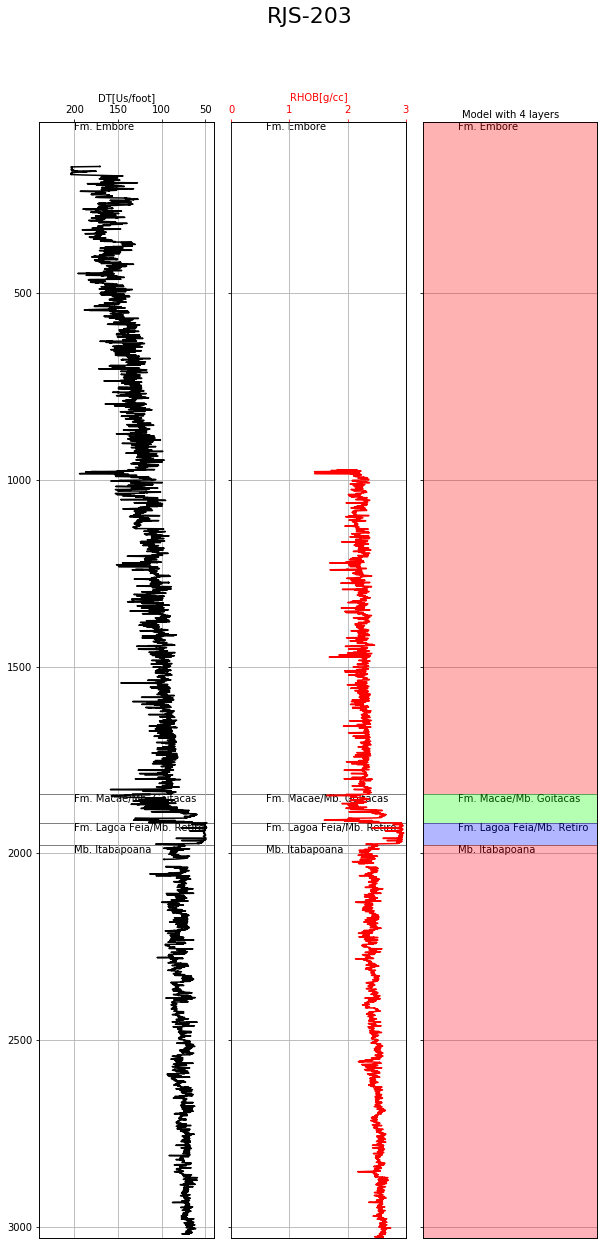

In [25]:
combo_plot(SB,DEPT_end)
#combo_plot(900,1000)   # apply zoom to your data in a specific interval

## Inserting geophysical markers

In [26]:
geof_markers = ('geof_1')

In [27]:
depths_geof_markers = (980)

In [28]:
markers = np.append(markers, geof_markers)

In [29]:
depths_markers = np.append(depths_markers, depths_geof_markers)

## Creating sub-layers to analyse the vicinities of the markers

Choose below the thickness of the sub-layers you would like to model above and below of each marker:

Use zero (0) for no sub-layers.

In [30]:
sub_layer_thickness = 0.

In [34]:
depths_bottom = np.sort(np.append(depths_markers[1:], DEPT_end))
depths_bottom

array([  980. ,  1842. ,  1918. ,  1977. ,  3030.8])

In [35]:
N_markers = len(markers)

for i in range(N_markers):
    idx_top = (np.abs(DEPT - depths_markers[i])).argmin()
    idx_bottom = (np.abs(DEPT - depths_bottom[i])).argmin()
    
    globals()['layer%s' % i] = DEPT[idx_top:idx_bottom]

In [36]:
sub_markers_top = []

for i in range(1, N_markers):
    sub_markers_t = depths_markers[i] - sub_layer_thickness
    sub_markers_top = np.append(sub_markers_top, sub_markers_t)

print sub_markers_top

[ 1842.  1918.  1977.   980.]


In [37]:
sub_markers_bottom = []
    
for i in range(1, N_markers):
    
    sub_markers_b = depths_markers[i] + sub_layer_thickness
    sub_markers_bottom = np.append(sub_markers_bottom, sub_markers_b)
    
print sub_markers_bottom

[ 1842.  1918.  1977.   980.]


In [38]:
total_layers = np.append(depths_markers, sub_markers_top)
total_layers = np.append(total_layers, sub_markers_bottom)
total_layers = np.append(total_layers, DEPT_end)
total_layers = np.unique(np.sort(total_layers))
total_layers

array([   43. ,   980. ,  1842. ,  1918. ,  1977. ,  3030.8])

In [39]:
thickness_total_layers=[]

N = total_layers.size

for i in range(N-1):
    thickness_t = total_layers[i+1] - total_layers[i]
    thickness_total_layers = np.append(thickness_total_layers, thickness_t)

#np.set_printoptions(formatter={'float_kind':'{:f}'.format})    
print thickness_total_layers

[  937.    862.     76.     59.   1053.8]


In [40]:
idx=[]

for i in range(total_layers.size):
    id = (np.abs(DEPT - total_layers[i])).argmin()
    idx = (np.append(idx, id))

idx = idx.astype(int)
    
print idx

[    0  5413 11069 11568 11955 18870]


## Donwsampling the data

For visualization purposes, depending on the module used, the downsampling is necessary to improve the performance of the processing time.

In [41]:
step_res = logs.step*3

In [42]:
DEPT_res = np.arange(DEPT_start+step_res, DEPT_end, step_res)
DEPT_res

array([  155.4972,   155.9544,   156.4116, ...,  3029.4564,  3029.9136,
        3030.3708])

In [43]:
x = DEPT
y = DT
f = interpolate.interp1d(x, y)

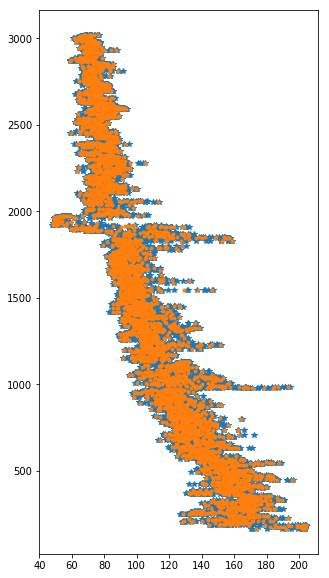

In [44]:
xnew = DEPT_res      # profundidade reamostrada
ynew = f(xnew)   # use interpolation function returned by `interp1d`

plt.figure(figsize=(5,10))
plt.plot(y, x, '*', ynew, xnew, '.')

plt.show()

In [45]:
DEPT.size

18871

In [46]:
DEPT_res.size

6289

## Calculating the time-depth table inside of the defined intervals

In seismic processing, the interval velocity is defined based on pairs of reflectors, according to Yilmaz (2001):

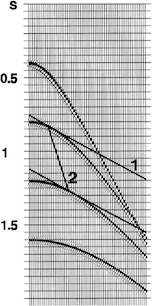

In [47]:
from IPython.display import Image
Image("imagens/interval_vel.png")

Inside of that intervals, defined by reflectors, the average velocity is calculated by the following expression (Yilmaz, 2001):

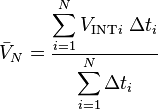

In [48]:
from IPython.display import Image
Image("imagens/average_vel.png")

Here, I am considering each geological marker as a reflector, because both by definition represent the same event: an interface that presents some change in petrophysical properties. To calculate the average velocity here I use as V_int the values shown in the logs associated with the depth of the marker or sub-marker. For simplification, I am not considering the influence of the time or depth but I checked that the error associated with this simplification is smaller than 0.0001%. If I would use the depth instead of the time, I would have to change the units of the logs from microsseconds per foot (DT) to meters and from grams per cubic centimeter (RHOB) to meters. I've noticed that the error is greater with the increase of the depth, but, as I wrote before, the error is insignificant for this purpose.

### *Average velocity*

In [49]:
average_vel=[]
for i in range(idx.size - 1):
    v_m = np.nanmean(DT[idx[i]:idx[i+1]])
    average_vel = np.append(average_vel, v_m)
               
print average_vel

[ 146.59135678  105.23509565  101.10859719   54.49405426   76.79206515]


### *Average density*

In [50]:
average_density=[]

for i in range(idx.size-1):
    RHOB_m = np.nanmean(RHOB[idx[i]:idx[i+1]])
    average_density = np.append(average_density, RHOB_m)
               
print average_density

[ 1.85942667  2.25002611  2.2593511   2.86890672  2.47169296]


### *Creating an array indexed to the depth for the interval velocity and density*

In [51]:
DT_int=np.zeros(DT.size)

for i in range(average_vel.size):
    DT_int[idx[i]:idx[i+1]] = average_vel[i]
    
DT_int = np.where(DT_int == 0, np.nan, DT_int)

print DT_int

[ 146.59135678  146.59135678  146.59135678 ...,   76.79206515   76.79206515
           nan]


In [52]:
RHOB_int=np.zeros(RHOB.size)

for i in range(average_density.size):
    RHOB_int[idx[i]:idx[i+1]] = average_density[i]
    
RHOB_int = np.where(RHOB_int == 0, np.nan, RHOB_int)

print RHOB_int

[ 1.85942667  1.85942667  1.85942667 ...,  2.47169296  2.47169296
         nan]


### *Calculating the acoustic impedance for each interval*

In [53]:
Image("imagens/Imp.jpg")

Where: $I$ = Acoustic Impedance, $V_{int}$ = Interval Velocity and $\rho$ = Interval porosity

In [54]:
IMP=[]

for i in range(average_density.size):
    I = (1/average_vel[i])*average_density[i]
    IMP = np.append(IMP, I)
print IMP

[ 0.01268442  0.02138095  0.02234579  0.05264623  0.03218683]


### *Calculating the reflexion coefficients for each interface*

The reflexion coefficients are an adimensional parameter. Because of this it's not necessary to be worried about units. The coefficients can be found by the following formula:

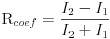

In [55]:
Image("imagens/coef.jpg")

Where: $I$ = Acoustic Impedance

In [56]:
coef_ref = []

for i in range(IMP.size-1):
    coef = (IMP[i+1]-IMP[i])/(IMP[i+1]+IMP[i])
    coef_ref = np.append(coef_ref, coef)

nan = []

for i in range(coef_ref.size):
    n = math.isnan(coef_ref[i])
    nan = np.append(nan, n)
    null = np.where(nan >0)
    np.put(coef_ref, null, 0)

    
print coef_ref

[ 0.25528934  0.02206518  0.40404896 -0.24117256]


In [57]:
# Assign the reflexion coefficients to the depth indices:

In [58]:
depth_coef = DEPT[idx[1:-1]]      # remove the first and last values associated with the start and end of the logs.
depth_coef

array([  979.98,  1842.  ,  1918.  ,  1977.  ])

### * Creating a ricker pulse to be convolved with the reflexion coefficients*

*Code source: Agile Geosciences*

In [59]:
def ricker(f, length=0.512, dt=0.004):
    t = np.arange(-length/2, length/2, dt)
    y = (1.-2.*(np.pi**2)*(f**2)*(t**2))*np.exp(-(np.pi**2)*(f**2)*(t**2))
    
    return t, y

In [60]:
f = 5.      # seismic dominant frequency
t, wavelet = ricker (f)

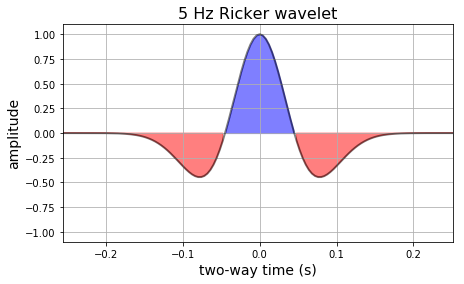

In [61]:
plt.figure(figsize=(7,4))
plt.plot( t, wavelet, lw=2, color='black', alpha=0.5)
plt.fill_between(t, wavelet, 0,  wavelet > 0.0, interpolate=False, color='blue', alpha = 0.5)
plt.fill_between(t, wavelet, 0, wavelet < 0.0, interpolate=False, color='red', alpha = 0.5)

# Axes configuration and settings (optional)
plt.title('%d Hz Ricker wavelet' %f, fontsize = 16 )
plt.xlabel( 'two-way time (s)', fontsize = 14)
plt.ylabel('amplitude', fontsize = 14)
plt.ylim((-1.1,1.1))
plt.xlim((min(t),max(t)))
plt.grid()
plt.show()

In [62]:
# Creating a new array to index the depth to the reflexion coefficients

In [63]:
idx_markers = idx[1:-1]
idx_markers

array([ 5413, 11069, 11568, 11955])

In [64]:
# checking the indices which have values different from zero

In [65]:
sint_sismo = np.zeros(DEPT.size)
np.put(sint_sismo, [idx_markers], [coef_ref])
np.where(sint_sismo != 0)

(array([ 5413, 11069, 11568, 11955]),)

## Generating the synthetic seismogram

The synthetic seismogram is the result of the convolution between the reflexion coefficients and the wavelet created above.

In [66]:
seismogram = np.convolve(sint_sismo, wavelet, mode='same')
seismogram.size

18871

## Plotting the results

In [67]:
title = 'Section of the well 1RJS-0203'

In [68]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


# Create the figure and subplots
def combo_plot(top_depth,bottom_depth):
    
    #plt.hold(True)
    
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16,9), sharey=True)
    fig.suptitle(title, fontsize=22)
    fig.subplots_adjust(top=0.8,wspace=0.1)
    
#General setting for all axis
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False) 
        for (i,j) in zip(depths_markers,markers):
            if ((i>=top_depth) and (i<=bottom_depth)):
                axes.axhline(y=i, linewidth=0.5, color='black')
                axes.text(0.2, i ,j, horizontalalignment='left',verticalalignment='top')
    
#1st track: DT
    
    ax01=ax[0].twiny()
    ax01.set_xlim(240.0,40.0)
    ax01.spines['top'].set_position(('outward',0))
    ax01.set_xlabel("DT [Us/foot]")
    ax01.plot(DT, DEPT, label='DT[Us/foot]', color='black')
    ax01.set_xlabel('DT[Us/foot]',color='black')    
    ax01.tick_params(axis='x', colors='black')
    ax01.grid(True)
    
    ax02=ax[0].twiny()
    ax02.set_xlim(240.0,40.0)
    ax02.spines['top'].set_position(('outward',40))
    ax02.set_xlabel("DT [Us/foot]")
    ax02.plot(DT_int, DEPT, label='DT[Us/foot]', color='orange')
    ax02.set_xlabel('Interval Velocity',color='orange')    
    ax02.tick_params(axis='x', colors='orange')
    ax02.grid(True)
    
#2nd track: RHOB

    ax11=ax[1].twiny()
    ax11.set_xlim(0,3.0)
    ax11.grid(True)
    ax11.spines['top'].set_position(('outward',0))
    ax11.set_xlabel('RHOB[g/cc]', color='red')
    ax11.plot(RHOB, DEPT, label='RHOB[g/cc]', color='red')
    ax11.tick_params(axis='x', colors='red') 
    
    ax11=ax[1].twiny()
    ax11.set_xlim(0,3.0)
    ax11.grid(True)
    ax11.spines['top'].set_position(('outward',40))
    ax11.set_xlabel('Interval Density', color='black')
    ax11.plot(RHOB_int, DEPT, label='RHOB[g/cc]', color='black')
    ax11.tick_params(axis='x', colors='black')
    
    
#3nd track: COEF
    
    ax21=ax[2].twiny()
    ax21.set_xlim(-1,1)
    ax21.spines['top'].set_position(('outward',0))
    ax21.set_xlabel("Reflexion Coefficients")
    
    x = coef_ref
    y = depth_coef
    
    ax21.hlines(y, 0, x, color='red')
    ax21.plot(x, y, 'D')  # Stem ends
    ax21.grid(True)   
    
#4nd track: Synthetic Seismogram
    
    ax31=ax[3].twiny()
    ax31.set_xlim(-1,1)
    ax31.spines['top'].set_position(('outward',0))
    ax31.set_xlabel("Synthetic Seismogram")
    ax31.plot(seismogram, DEPT, lw=1, color='black', alpha=0.2)  
    ax31.fill_betweenx(DEPT, seismogram, 0., seismogram > 0., interpolate=False, color='blue', alpha = 0.5)
    ax31.fill_betweenx(DEPT, seismogram, 0., seismogram < 0., interpolate=False, color='red', alpha = 0.5)
    
    ax31.grid(True)   
    
#5nd track: Layers

    NL = total_layers.size-1
    cmap = get_cmap(NL)
    
    ax41=ax[4].twiny()
    ax41.set_xlim([ -150, 150])
    ax41.grid(True)
    
    x = 'Model with'
    y = NL
    z = 'layers'
    
    ax41.set_xlabel('%s %s %s'%(x, y, z), color='black')
    
    
    
    for i in range(NL):
        rect = plt.Rectangle((-150, total_layers[i]), 300, thickness_total_layers[i], alpha = 0.2, facecolor=cmap(i))
        ax41.add_artist(rect)
        
    ax41.set_xticks([])
    
    
    #plt.savefig ('RJS_51.png', dpi=200, format='png')

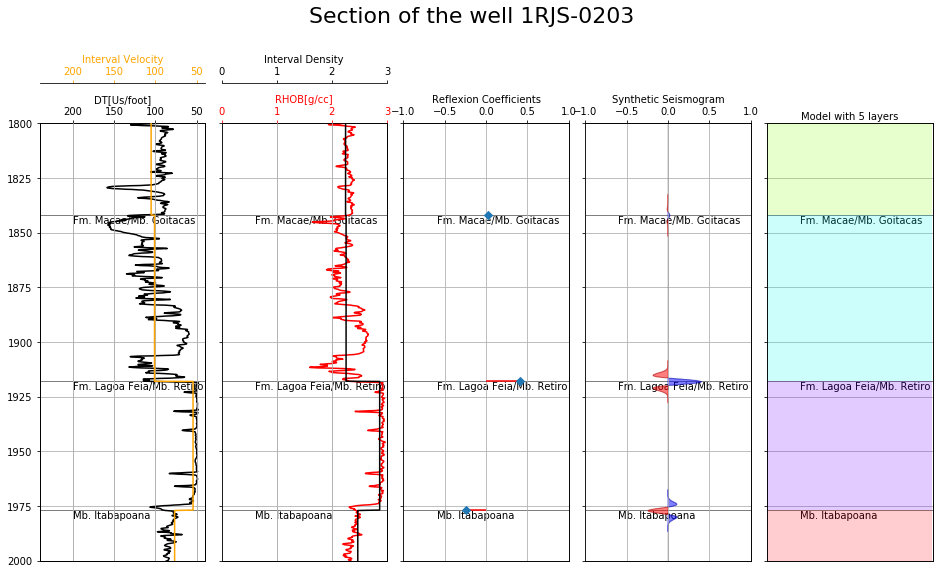

In [71]:
#combo_plot(SB,DEPT_end)
combo_plot(1800,2000)

## Solving problems related to the data acquisition

It's possible that the data present sometimes gaps in one or in all the logs as you can verify below:

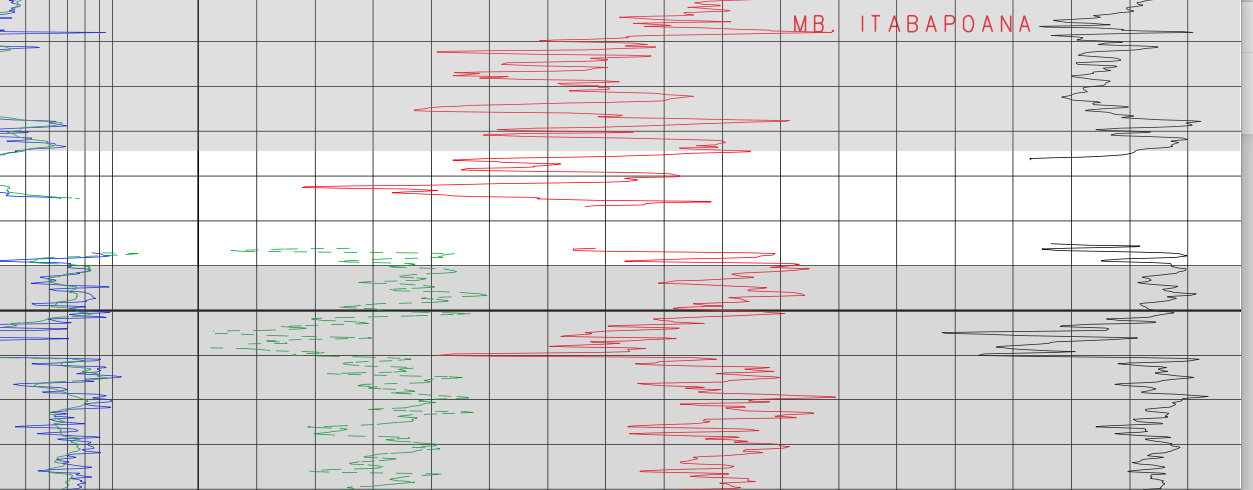

In [72]:
Image("imagens/falha_perfil_composto.png")

What to do in those situations? I tried to import the data, as it is, into the software OpendTect but the result was this:

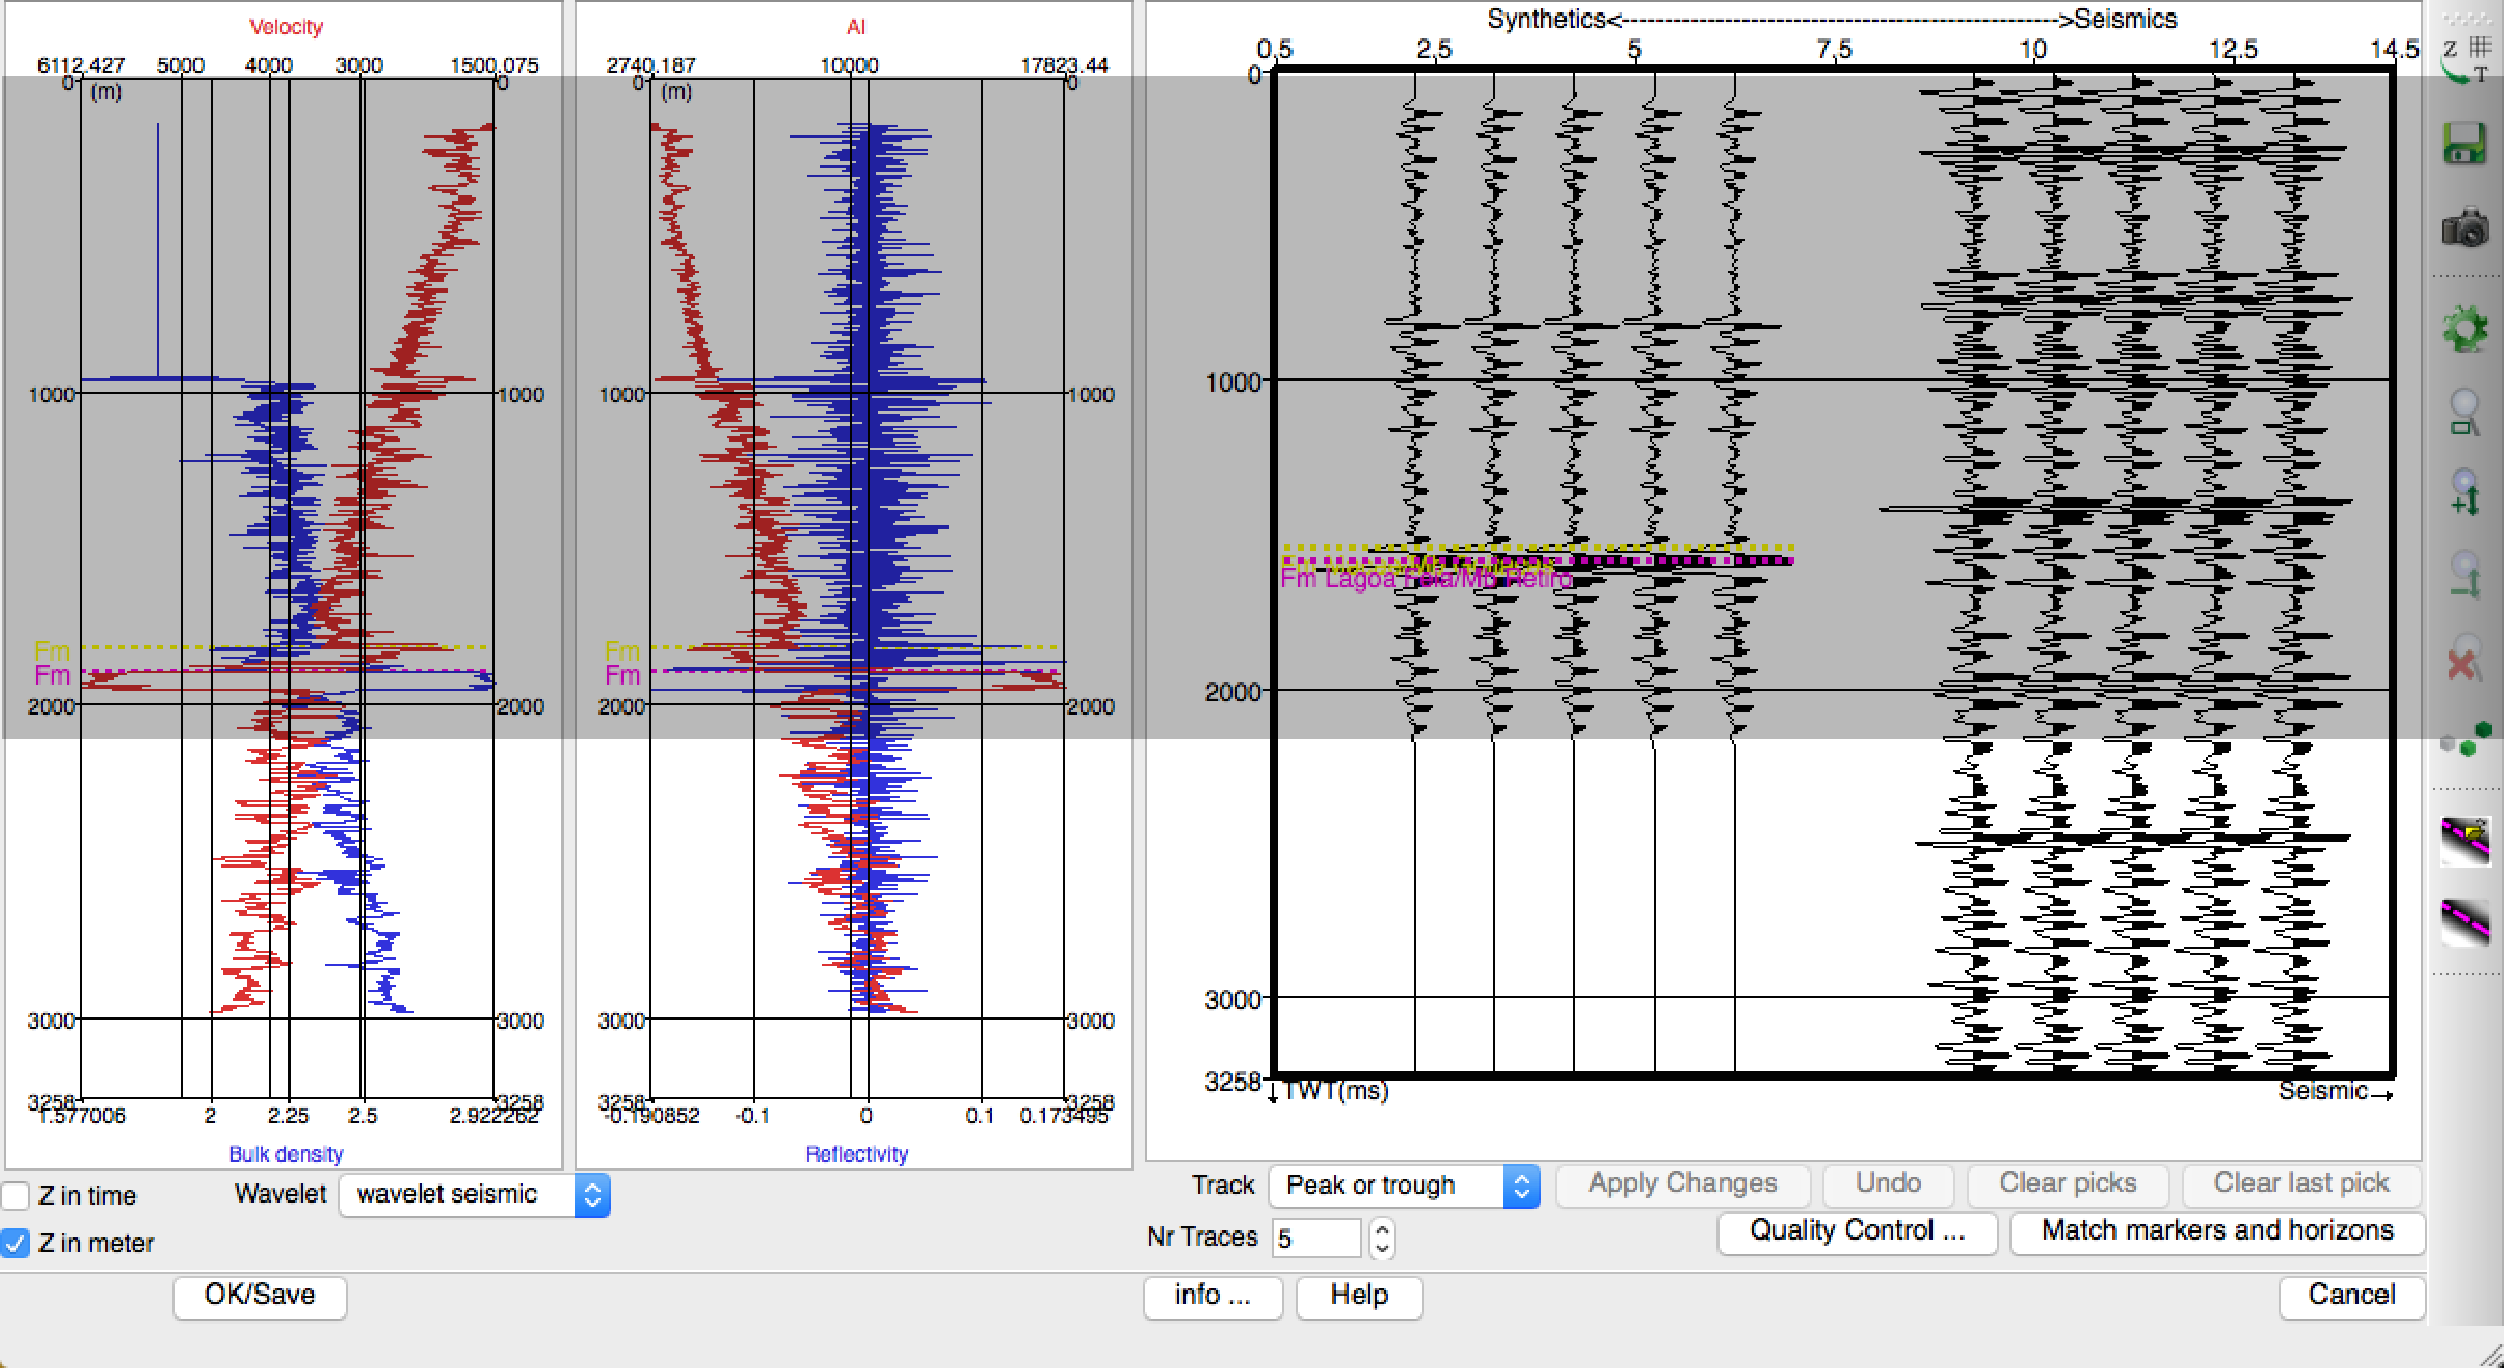

In [73]:
Image("imagens/amarracao_ODT.png")

Observe that below the depth of 2000 m there is no synthetic seismogram, even though the data of velocity and density are there. This problem is caused by that interruption of both logs - sonic and bulk density. See below how it appears at the raw data:

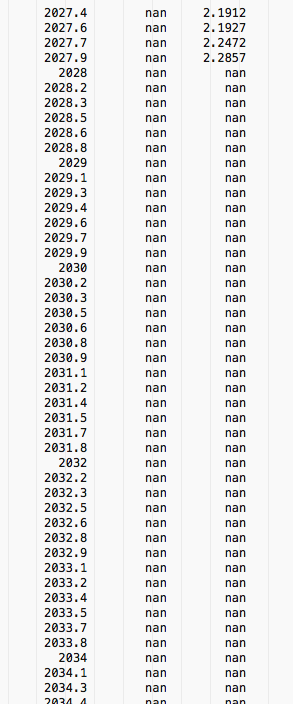

In [74]:
Image("imagens/falha_dados_las.png")

Observe at the image below that the density log, when was not present, the program automatically estimated an average value:

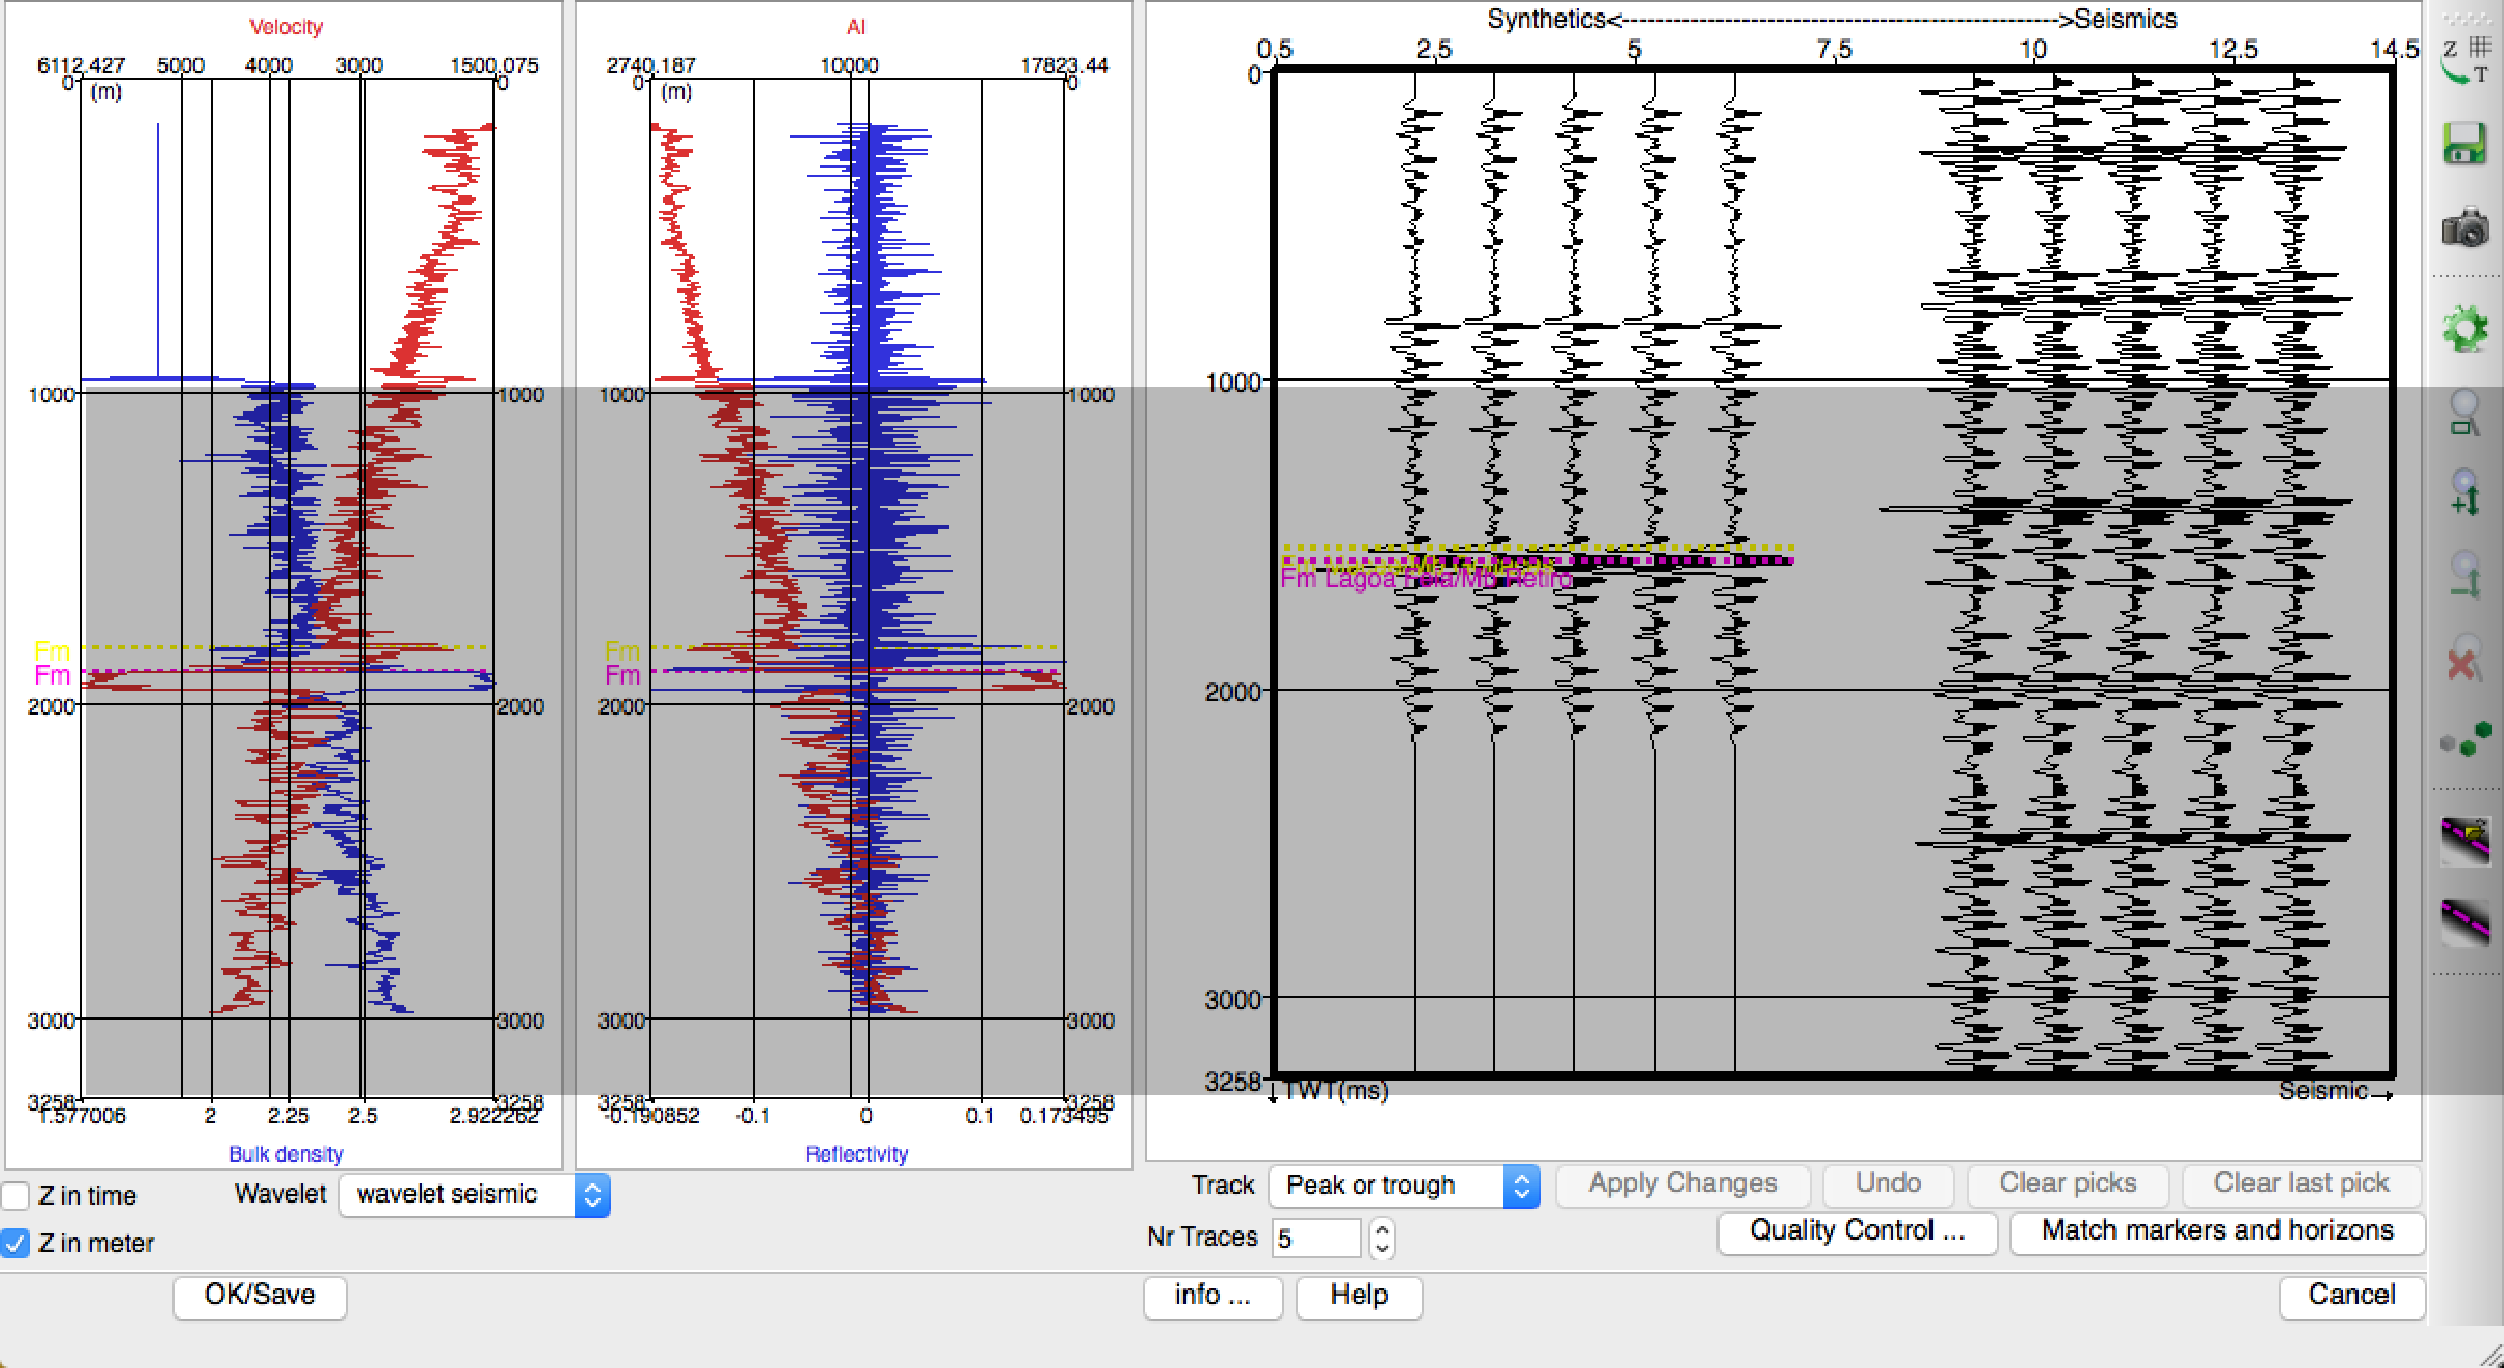

In [75]:
Image("imagens/amarracao_ODT_density.png")

But, for that small interval, in the middle of the log, it could not be solved.

In the next notebook you will learn how to estimate yourself values for Vp and for RHOB based on Gardner's equations.

## Exporting the time-depth table

The sonic travel time is known as <b>slowness</b>. Because of this we see that the log curve has a tendency to have lower velocities with the increase of the depth. But the velocity used for the time-depth convertion is known as <b>RMS (root-mean-square) velocity </b> and it is the inverse of the sonic travel time. The unit that fits in the equation used is m/s.

In [76]:
average_vel   # slowness in Us/foot (microsseconds per foot)

array([ 146.59135678,  105.23509565,  101.10859719,   54.49405426,
         76.79206515])

In [77]:
# Converting the DT log from microsseconds to seconds and from foot to meter:

In [78]:
Vp = (1e6 / average_vel) * 0.3048       # Converting from microsseconds to seconds and inverting the log
Vp  

array([ 2079.24946386,  2896.37214767,  3014.58044576,  5593.27075438,
        3969.16008713])

In [79]:
# It's necessary to add the velocity of the P wave for the salty water before the first index (in marine surveys):

In [80]:
Vp_water = 1500   # m/s

In [81]:
Vp = np.insert(Vp, 0, Vp_water)
Vp         # in meters per second

array([ 1500.        ,  2079.24946386,  2896.37214767,  3014.58044576,
        5593.27075438,  3969.16008713])

In [82]:
# And update the thickness of the layers with the water depth

In [83]:
thickness_total_layers = np.insert(thickness_total_layers, 0, SB)
thickness_total_layers 

array([   43. ,   937. ,   862. ,    76. ,    59. ,  1053.8])

In [84]:
for i in range(Vp.size):    # replacing null values by the average of the neighbors 

    if pd.isnull(Vp[i]) == True:
        Vp[i] = (Vp[-i]+Vp[+i])/2
print Vp

[ 1500.          2079.24946386  2896.37214767  3014.58044576  5593.27075438
  3969.16008713]


### Calculating the time to cross each layer:

In seismic sections the time displayed is related to the two way travel time. Because of it we need to multiply the thickness per 2.

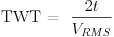

In [85]:
Image("imagens/TWT.jpg")

Where: $t$ = thickness of the layers and $V_{RMS}$ = RMS velocity

In [86]:
ti=0
time = []

for i in range(Vp.size):
    t = thickness_total_layers[i]*2/ Vp[i]    
    ti = (t + ti) 
    time = np.append(time, ti)

time = time * 1000 *1      # in milliseconds
    
print time      

[   57.33333333   958.62008731  1553.8474656   1604.26907575  1625.36585529
  2156.35980709]


In [87]:
Time = np.array([time])
Time.T

array([[   57.33333333],
       [  958.62008731],
       [ 1553.8474656 ],
       [ 1604.26907575],
       [ 1625.36585529],
       [ 2156.35980709]])

In [91]:
depth = total_layers
depth

Depth = np.array([depth])   # Measured depth
Depth.T

array([[   43. ],
       [  980. ],
       [ 1842. ],
       [ 1918. ],
       [ 1977. ],
       [ 3030.8]])

In [89]:
time_depth_table = np.concatenate((Depth.T, Time.T), axis=1)
time_depth_table

array([[   43.        ,    57.33333333],
       [  980.        ,   958.62008731],
       [ 1842.        ,  1553.8474656 ],
       [ 1918.        ,  1604.26907575],
       [ 1977.        ,  1625.36585529],
       [ 3030.8       ,  2156.35980709]])

In [90]:
np.savetxt('time_depth_table.txt', time_depth_table, fmt='%10.4f', delimiter='    ', newline='\n', header='', footer='', comments='# ') 